# Rescoring Docking Poses

## Overview

This project evaluates and rescoring docking poses generated using AutoDock Vina based on three key criteria:

1. Binding Affinity (VINA score)
2. Hydrogen Bonding (stabilization potential)
3. Pose Clustering (consistency of similar poses)

Each criterion is normalized, and a final composite score is computed, with binding affinity given the highest weight, followed by H-bonding and clustering.


## Justification for Scoring Criteria

Binding Affinity: Prioritized as it directly represents the ligand’s predicted binding strength to the target. Lower binding energy suggests a more stable and favorable interaction.

H-Bonding: Ligands forming more hydrogen bonds are often more stable, as H-bonds contribute significantly to specificity and affinity.

Pose Clustering: A pose that appears frequently in clustering is likely more reliable, as it suggests a preferred binding mode.
Methodology

Normalization: Each score was normalized within its dataset (0 to 1 scale).

Rescoring: Final scores were computed using a weighted approach prioritizing affinity at 50% weight, H-bonding at 30% weight and clustering at 20%.

Analysis: Results were compared with published crystal structures to assess accuracy.

## Discussion & Limitations:

Comparison with Published Structures: The top poses were analyzed against experimental structures to evaluate deviations.

Potential Deviations: Differences may arise due to protein flexibility, solvent effects, or limitations in docking algorithms.

Clustering Reliability: Some ligands showed low clustering scores, suggesting binding promiscuity or scoring inaccuracies.

In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from MDAnalysis import Universe
from sklearn.cluster import AgglomerativeClustering
import os
import re

# ==============================================
# 1. Parse Docking Results from VINA
# ==============================================


def parse_vina_log(log_file):
    modes = []
    affinities = []
    rmsd_lb = []
    rmsd_ub = []

    # Read the log file
    with open(log_file, "r") as file:
        lines = file.readlines()

    # Parse the relevant lines
    for line in lines:
        if re.match(r"^\d+", line.strip()):   # Check for pose lines
            parts = line.split()
            modes.append(int(parts[0]))  # Mode number
            affinities.append(float(parts[1]))  # Affinity
            rmsd_lb.append(float(parts[2]))  # RMSD lower bound
            rmsd_ub.append(float(parts[3]))  # RMSD upper bound

    # Create a DataFrame
    df = pd.DataFrame({
        "Mode": modes,
        "Affinity (kcal/mol)": affinities,
        "RMSD Lower Bound (Å)": rmsd_lb,
        "RMSD Upper Bound (Å)": rmsd_ub,
    })
    
    return df


vina_dfs = {}
ligands = []

for folder in os.listdir():
    if os.path.isdir(folder):
        vina_log_path = os.path.join(folder, "vina.log")
        # Check if vina.log exists
        if os.path.exists(vina_log_path):
            vina_dfs[folder] = parse_vina_log(vina_log_path)
            ligands.append(folder)
            
            
            
# ==============================================
# 2. Append columns with H-bonding data, derived from ViewDockX on ChimeraX
# ==============================================

hbond_file = "h_bonds.xlsx"

for ligand in vina_dfs.keys():
    # Read the ligand's corresponding sheet from the Excel file
    hbond_df = pd.read_excel(hbond_file, sheet_name=ligand)
    
    # Ensure pose numbers are treated as integers for correct matching
    hbond_df["Mode"] = hbond_df["Mode"].astype(int)
    
    # Merge H-bond data into the docking DataFrame based on "Mode"
    vina_dfs[ligand] = vina_dfs[ligand].merge(hbond_df[["Mode", "HBONDS"]], on="Mode", how="left")
    

# Verify the first few rows to confirm the merge
vina_dfs[ligand].head()


,Mode,Affinity (kcal/mol),RMSD Lower Bound (Å),RMSD Upper Bound (Å),HBONDS
0,1,-8.2,0.000,0.000,0
1,2,-8.2,0.151,2.376,0
2,3,-8.1,8.159,12.503,2
3,4,-8.1,8.130,12.713,2
4,5,-7.7,8.182,12.957,0



Clustering poses for lenvatinib ...


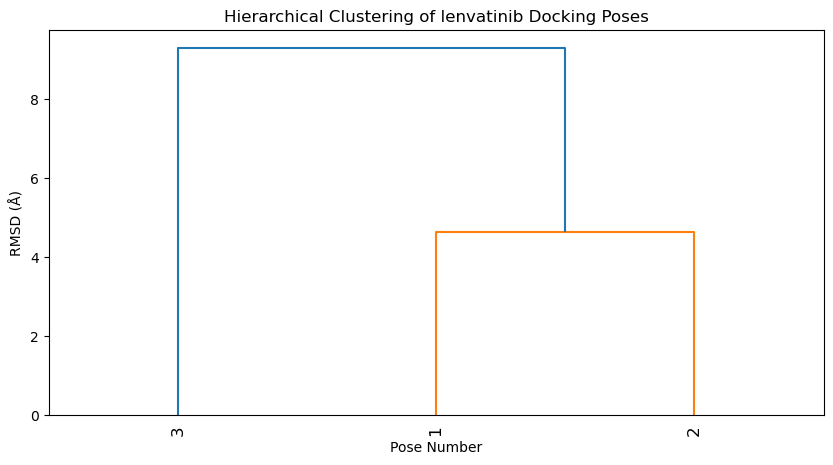

Updated clustering scores for lenvatinib

Clustering poses for pazopanib ...


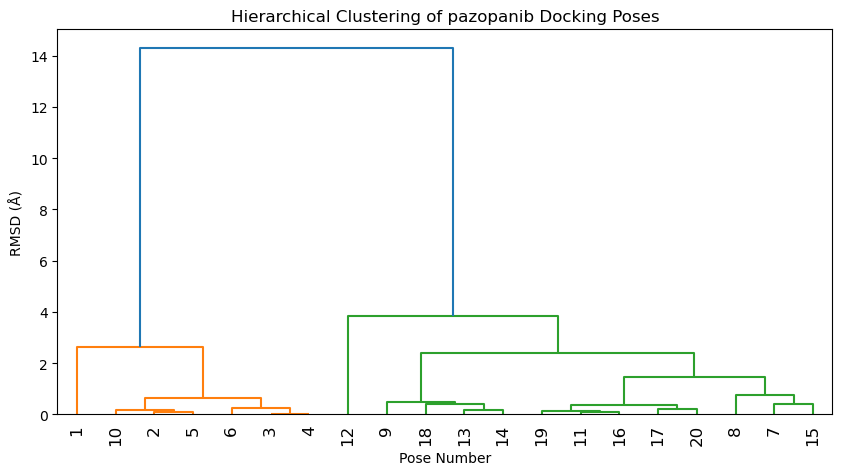

Updated clustering scores for pazopanib

Clustering poses for sorafenib ...


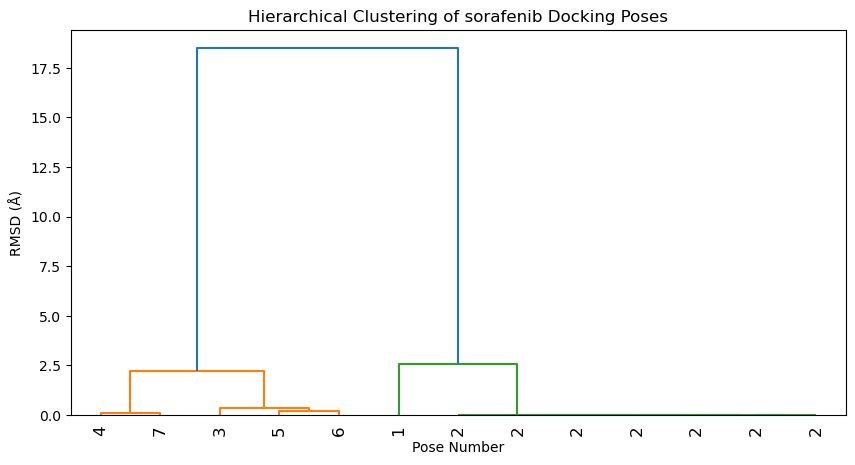

Updated clustering scores for sorafenib

Clustering poses for sunitinib ...


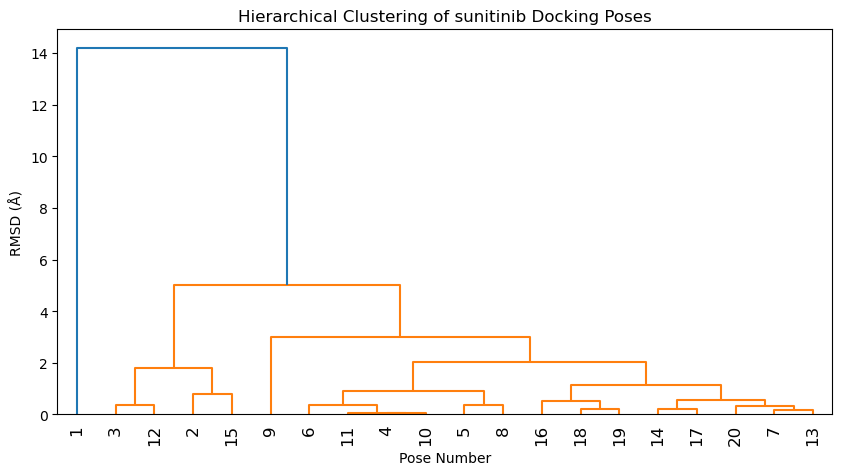

Updated clustering scores for sunitinib

Clustering poses for DB08519 ...


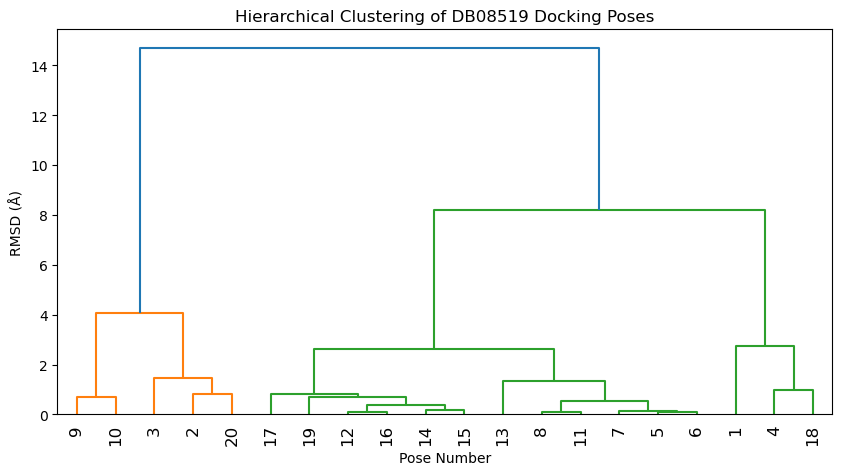

Updated clustering scores for DB08519

Clustering poses for DB08042 ...


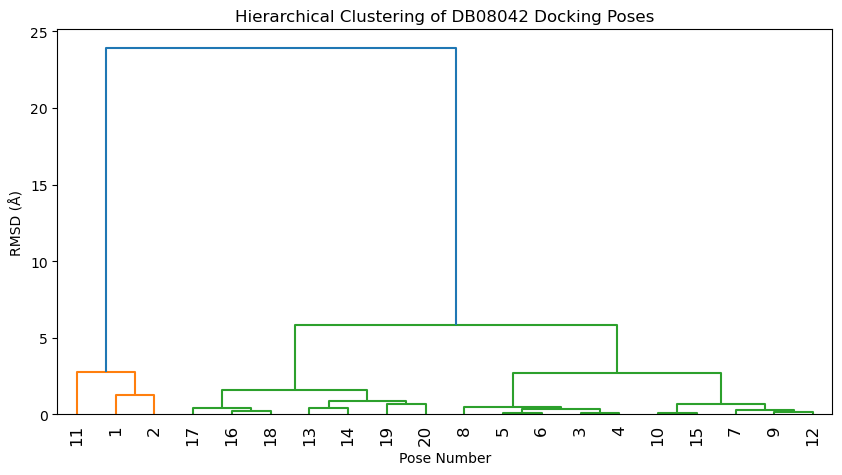

Updated clustering scores for DB08042


In [3]:
# ==============================================
# 3. Hierarchical clustering of poses based on RMSD values
# ==============================================

import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt

def build_rmsd_matrix(df):
    """
    Constructs an RMSD matrix using both lower and upper bounds from vina.log.
    This should better approximate the true RMSD differences.
    """
    n = len(df)
    rmsd_matrix = np.zeros((n, n))  # NxN RMSD matrix

    for i in range(n):
        for j in range(i+1, n):  # Upper triangle only
            rmsd_lb_diff = abs(df.loc[i, "RMSD Lower Bound (Å)"] - df.loc[j, "RMSD Lower Bound (Å)"])
            rmsd_ub_diff = abs(df.loc[i, "RMSD Upper Bound (Å)"] - df.loc[j, "RMSD Upper Bound (Å)"])
            rmsd_matrix[i, j] = rmsd_matrix[j, i] = (rmsd_lb_diff + rmsd_ub_diff) / 2  # Average of both

    return rmsd_matrix

def cluster_vina_poses(df, ligand_name):
    """
    Clusters docking poses using hierarchical clustering on RMSD.
    """
    rmsd_matrix = build_rmsd_matrix(df)
    condensed_rmsd = ssd.squareform(rmsd_matrix)  # Convert to condensed format

    linkage_matrix = sch.linkage(condensed_rmsd, method="ward")

    # Plot dendrogram
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, labels=df["Mode"].astype(str).tolist(), leaf_rotation=90)
    plt.title(f"Hierarchical Clustering of {ligand_name} Docking Poses")
    plt.xlabel("Pose Number")
    plt.ylabel("RMSD (Å)")
    plt.show()

    return linkage_matrix
        
def score_pose_clustering(df, threshold=1.0):
    """
    Scores each pose based on the number of other poses within a given RMSD threshold.
    Returns a DataFrame with an added "Clustering Score".
    """
    rmsd_matrix = build_rmsd_matrix(df)  # Get NxN RMSD matrix
    clustering_scores = []

    for i in range(len(df)):
        count_within_threshold = np.sum(rmsd_matrix[i] <= threshold) - 1  # Exclude itself
        clustering_scores.append(count_within_threshold)

    df["Clustering Score"] = clustering_scores  # Add scores to DataFrame
    if "HBONDS" not in df.columns:
        print("⚠️ Warning: HBONDS column missing after clustering!")

    return df


for ligand, df in vina_dfs.items():
    print(f"\nClustering poses for {ligand} ...")
    cluster_vina_poses(df, ligand)  # Perform clustering for this specific ligand
    print(f"Updated clustering scores for {ligand}")
    vina_dfs[ligand] = score_pose_clustering(df)

In [4]:
vina_dfs[ligand].head()

,Mode,Affinity (kcal/mol),RMSD Lower Bound (Å),RMSD Upper Bound (Å),HBONDS,Clustering Score
0,1,-8.2,0.000,0.000,0,0
1,2,-8.2,0.151,2.376,0,0
2,3,-8.1,8.159,12.503,2,4
3,4,-8.1,8.130,12.713,2,4
4,5,-7.7,8.182,12.957,0,4


In [17]:
# ==============================================
# 4. Normalising all scores and final computation of overall scores
# ==============================================



def normalize_column(df, column_name, invert=False):
    """
    Normalizes a column in a DataFrame using Min-Max scaling.
    If invert=True, higher values become lower (used for affinity).
    """
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    
    if max_val - min_val == 0:
        df[f"Normalized {column_name}"] = 0.5  # Avoid division by zero
    else:
        if invert:
            df[f"Normalized {column_name}"] = (max_val - df[column_name]) / (max_val - min_val)
        else:
            df[f"Normalized {column_name}"] = (df[column_name] - min_val) / (max_val - min_val)
    
    return df

def compute_final_scores(df, w_hb=0.3, w_clust=0.2, w_aff=0.5):
    """
    Normalizes scores and computes a weighted final score.
    """
    df = normalize_column(df, "HBONDS")
    df = normalize_column(df, "Clustering Score")
    df = normalize_column(df, "Affinity (kcal/mol)", invert=True) 
    
    # Compute Final Score
    df["Final Score"] = (
        w_hb * df["Normalized HBONDS"] +
        w_clust * df["Normalized Clustering Score"]+
        w_aff * df["Normalized Affinity (kcal/mol)"]
    )
    
    # Rank poses (1 = best)
    df["Rank"] = df["Final Score"].rank(ascending=False, method="dense").astype(int)
    
    return df.sort_values(by="Final Score", ascending=False)

# Apply to all ligands
for ligand, df in vina_dfs.items():
    vina_dfs[ligand] = compute_final_scores(df)
    print(f"✅ Computed final scores for {ligand}")


✅ Computed final scores for DB08042
✅ Computed final scores for DB08519
✅ Computed final scores for lenvatinib
✅ Computed final scores for pazopanib
✅ Computed final scores for sorafenib
✅ Computed final scores for sunitinib


In [19]:
with pd.ExcelWriter("rescoring_results.xlsx") as writer:
    for ligand, df in vina_dfs.items():
        df.to_excel(writer, sheet_name=ligand, index=False)

print("✅ Docking results saved to rescoring_results.xlsx")

✅ Docking results saved to docking_results.xlsx
